In [1]:
import numpy as np
import anndata
import scanpy as sc
import mudata as md
from scipy import sparse

In [2]:
import matplotlib.pyplot as plt

# Getting started with the `anndata` and `mudata` packages

Suppose a colleague of yours did some single cell data analysis in Python and Scanpy, saving the results in an `AnnData` object and sending it to you in a `*.h5ad` file. This tutorial will walk you through that file and help you explore its structure and content --- even if you are new to anndata, mudata, Scanpy or Python.

In this tutorial, we will refer to anndata and mudata as the packages, and to their data structures as `AnnData` and `MuData` objects, respectively.

## Exploring the `AnnData` object

We will use a preprocessed PBMC data set for our example. It comes from the `scanpy.dataset` module, and the following line downloads the file `pbmc3k_processed.h5ad` into `./data` and loads it as `AnnData` object into python.

In [3]:
adata = sc.datasets.pbmc3k_processed()
adata = adata.raw.to_adata()
adata.layers["raw"] = sparse.csr_matrix((np.exp(adata.X.A) - 1).astype(int))
adata.X = sc.pp.log1p(sc.pp.normalize_total(adata, layer="raw", inplace=False)["X"])

(To load any `*.h5ad`file that already is on you machine, you would use `adata = anndata.read_h5ad('path/to/file.h5ad')`)

Let's have a first look at the `AnnData` object:

In [4]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    layers: 'raw'
    obsp: 'distances', 'connectivities'

This output tells us some general things about the data: its shape (2638 cells, 13714 genes) and which metadata fields and subfields it has. We will go through those one-by-one - let's start with the most important one:

### The *active* data matrix in `adata.X`

![Active data matrix X](img/X.png "Active data matrix X")

The `adata.X` slot holds the data matrix that we are actively using for analysis (e.g. for plotting gene expression values). That also means that most functions will use this data as input by default, unless explicitly told otherwise.

In this example, `adata.X` holds the matrix of normalized and log(1+x)-transformed mRNA counts. Its **rows are cells** (or observations), and its  **columns are genes** (or variables).

In [5]:
adata.X

<2638x13714 sparse matrix of type '<class 'numpy.float32'>'
	with 2238732 stored elements in Compressed Sparse Row format>

We see that the data matrix is stored in the [scipy sparse matrix format](https://docs.scipy.org/doc/scipy/reference/sparse.html) for compression. In brief, that means that we only store the non-zero expression values and their coordinates/indices in the data matrix explicitly, knowing that all other values are zeros. This saves a lot of RAM and makes processing faster, but also changes how we can interact with this object compared to a "normal" dense array. For an overview of the functions that you can apply directly on sparse arrays, check the [scipy.sparse docs for the csr array](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_array.html#scipy.sparse.csr_array). 

Here are some examples to show how the sparse format works:

In [6]:
# look at the non-zero values in the data
print(adata.X.data)
# look at their indices / positions in the data matrix
print(adata.X.indices)
# compute the fraction of non-zero entries
print(adata.X.nnz / np.product(adata.X.shape))

[0.6496621 0.6496621 1.0402015 ... 0.7506172 0.7506172 1.4713064]
[   29    73    80 ... 13702 13705 13708]
0.06188183317756446


### Alternative versions of the active data in `layers`

![Additional data layers with the same shape as X](img/layers.png "Additional data layers with the same shape as X")

The data representation that we want to use mostly for plotting and processing lives in `adata.X`, e.g. the normalized counts. In addition to that, we often want to keep additional versions of our data around, e.g. the raw counts. These versions must have the exact same shape as `adata.X` and can be found in `layers`. Technically, `layers` is a [Python dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) and stores each layer under a separate key.

In [7]:
adata.layers

Layers with keys: raw

Our data only has a single additional layer, the raw counts, accessible via the layer key `'raw'`:

In [8]:
adata.layers["raw"]

<2638x13714 sparse matrix of type '<class 'numpy.int64'>'
	with 2238732 stored elements in Compressed Sparse Row format>

Its also a sparse matrix with the same shape as the active data in `adata.X`, but with integer values:

In [9]:
adata.layers["raw"].data

array([1, 1, 2, ..., 1, 1, 3])

Now let's add a new layer, for example "counts per million"-normalized counts. We can compute it from the `raw` layer and store it in `layers` with a new name:

In [10]:
# copy raw counts to new layer
adata.layers["counts_per_million"] = adata.layers["raw"].copy()
# normalize the new layer to counts-per-million
sc.pp.normalize_total(adata, target_sum=10**6, layer="counts_per_million")
print(adata.layers)

Layers with keys: raw, counts_per_million


Also note that we had to explicitly tell the normalization function from Scanpy to use the new `counts_per_million` as input and output!

### Simple annotations for cells and genes in `obs` and `var`

We usually want to store annotations for each cell and gene in `adata.X`. For cells, this can be the cluster assignments, batch IDs or a quality metric; for genes, it might be the gene name, ensembl ID or some measure of variance. 

In `AnnData` objects, this information lives in `adata.obs` for cell annotations - each of its rows correspond to a row / cell in `adata.X`. Similarly, `var` holds the gene annotations.

![Simple annotations for cells and genes](img/obsvar.png "Simple annotations for cells and genes in `obs` and `var`")

In [11]:
adata.obs

,n_genes,percent_mito,n_counts,louvain
index,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells
...,...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3459.0,CD14+ Monocytes
TTTCTACTGAGGCA-1,1227,0.009294,3443.0,B cells
TTTCTACTTCCTCG-1,622,0.021971,1684.0,B cells


This table is a [Pandas Data Frame](https://pandas.pydata.org/). We can see from its columns that we currently have four cell annotations:
- the number of genes per cell
- fraction of ćounts from mitochondrial genes in each cell (a quality metric)
- total counts per cell
- cluster assignment of a louvain clustering

All of these annotations are one-dimensional - they contain a single number or string per cell. Also, each cell is uniquely identified by the index of the table - in this case, the cell barcoding sequence (more about indexing in the next section).

To get a list of all cell annotations in the `obs` columns, you can use

In [12]:
adata.obs_keys()

['n_genes', 'percent_mito', 'n_counts', 'louvain']

To access a specific column of the `obs` data frame, we can simply use its column name:

In [13]:
adata.obs["louvain"]

index
AAACATACAACCAC-1        CD4 T cells
AAACATTGAGCTAC-1            B cells
AAACATTGATCAGC-1        CD4 T cells
AAACCGTGCTTCCG-1    CD14+ Monocytes
AAACCGTGTATGCG-1           NK cells
                         ...       
TTTCGAACTCTCAT-1    CD14+ Monocytes
TTTCTACTGAGGCA-1            B cells
TTTCTACTTCCTCG-1            B cells
TTTGCATGAGAGGC-1            B cells
TTTGCATGCCTCAC-1        CD4 T cells
Name: louvain, Length: 2638, dtype: category
Categories (8, object): ['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells', 'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes']

Now, we can directly interact with these annotations, e.g. count the numbers of B cells in the data:

In [14]:
print(sum(adata.obs["louvain"] == "B cells"))

342


To add a new cell annotations, we simply add a new column to the `obs` data frame.

For example, if we want to keep track of low-quality cells with a high mitochondrial gene count fraction, we can do the following to mark all cells above a certain threshold:

In [15]:
adata.obs["is_low_quality"] = adata.obs["percent_mito"] > 0.03
adata.obs  # to inspect the updated table

,n_genes,percent_mito,n_counts,louvain,is_low_quality
index,,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells,True
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells,True
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells,False
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,False
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells,False
...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3459.0,CD14+ Monocytes,False
TTTCTACTGAGGCA-1,1227,0.009294,3443.0,B cells,False
TTTCTACTTCCTCG-1,622,0.021971,1684.0,B cells,False


The gene annotations in the `var` data frame work in the same way: Here, each row is a gene and in this example, the gene name is used as index.

In [16]:
adata.var

,n_cells
index,
AL627309.1,9
AP006222.2,3
RP11-206L10.2,5
RP11-206L10.9,3
LINC00115,18
...,...
AC145212.1,16
AL592183.1,323
AL354822.1,8


If you want to learn how to interact with the `obs` and `var` data frames in more advanced ways, you can have a look at these [Pandas tutorials](https://pandas.pydata.org/docs/getting_started/intro_tutorials/index.html).

### Index cells and genes with `obs_names` and `var_names`

One important aspect of `AnnData` objects is the shared indexing. Consider the case of cell annotations - no matter if we look at a cells raw counts, its cluster assignments or its k-nearest neighbors in the PCA space: we always want to be able to refer to the same cell with the same "name". That is why all cell annotations share the same index, the `obs_names`. Similarly, we have `var_names` indexing our genes and their annotations. These annotations should be unique and many functions in the scverse ecosystem will raise warnings if this is not the case.

![Shared indexing for cells and genes](img/names.png "Shared indexing for cells and genes")

For the cells in our example data, the cell barcode from sequencing is used as index.

In [17]:
adata.obs_names

Index(['AAACATACAACCAC-1', 'AAACATTGAGCTAC-1', 'AAACATTGATCAGC-1',
       'AAACCGTGCTTCCG-1', 'AAACCGTGTATGCG-1', 'AAACGCACTGGTAC-1',
       'AAACGCTGACCAGT-1', 'AAACGCTGGTTCTT-1', 'AAACGCTGTAGCCA-1',
       'AAACGCTGTTTCTG-1',
       ...
       'TTTCAGTGTCACGA-1', 'TTTCAGTGTCTATC-1', 'TTTCAGTGTGCAGT-1',
       'TTTCCAGAGGTGAG-1', 'TTTCGAACACCTGA-1', 'TTTCGAACTCTCAT-1',
       'TTTCTACTGAGGCA-1', 'TTTCTACTTCCTCG-1', 'TTTGCATGAGAGGC-1',
       'TTTGCATGCCTCAC-1'],
      dtype='object', name='index', length=2638)

Genes are indexed by gene name in this example:

In [18]:
adata.var_names

Index(['AL627309.1', 'AP006222.2', 'RP11-206L10.2', 'RP11-206L10.9',
       'LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1', 'RP11-54O7.17', 'HES4',
       ...
       'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'AC145212.1',
       'AL592183.1', 'AL354822.1', 'PNRC2-1', 'SRSF10-1'],
      dtype='object', name='index', length=13714)

### Multidimensional annotations for cells and genes in `obsm` and `varm`

In [19]:
adata.uns.keys()

dict_keys(['draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'])

Sometimes, the simple, one-dimensional annotations in `obs` and `var` are not enough to store the results of our analysis. 

For example, if we embed our data with t-SNE or UMAP, we usually obtain a two-dimensional vector of embedding coordinates for each cell. For a PCA with, say, 50 components, we would even get a 50-dimensional vector per cell. To store these multidimensional representations of the cells, `AnnData` objects provide the `obsm` object. 

![Multidimensional information for cells and genes in `obsm` and `varm`](img/obsmvarm.png "Multidimensional information for cells and genes in `obsm` and `varm`")

For multidimensional information about genes, we have `varm`, which works similarly and could e.g. hold the PCA loadings for each gene.

Now, let's have a look at our example `adata.obsm`:

In [20]:
adata.obsm

AxisArrays with keys: X_pca, X_tsne, X_umap, X_draw_graph_fr

In our example, it contains representation of our cells after PCA, t-SNE, UMAP and some graph method. Technically, these four representations are stored in a [Python dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) with separate keys.

We can look at the data shape for each of them:

In [21]:
for key in adata.obsm_keys():
    print(key, adata.obsm[key].shape, sep="\t")

X_pca	(2638, 50)
X_tsne	(2638, 2)
X_umap	(2638, 2)
X_draw_graph_fr	(2638, 2)


The numbers of observations always has to be the same as in `adata.X`, but the number of dimensions can vary.

Also, let's make a simple plot of the the first two PCs from PCA and the UMAP / t-SNE embeddings, and highlight the B cells:

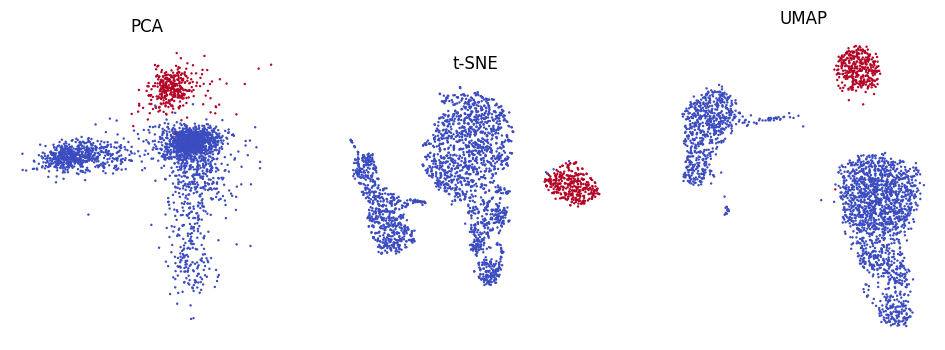

In [22]:
plt.figure(figsize=(12, 4))

# PCA
plt.subplot(1, 3, 1)
plt.scatter(
    x=adata.obsm["X_pca"][:, 0],  # PCA dim 1
    y=adata.obsm["X_pca"][:, 1],  # PCA dim 2
    c=adata.obs["louvain"] == "B cells",  # B cell flag
    s=3,
    linewidth=0,
    cmap="coolwarm",
)
plt.title("PCA")
plt.axis("off")
plt.gca().set_aspect("equal")

# t-SNE
plt.subplot(1, 3, 2)
plt.scatter(
    x=adata.obsm["X_tsne"][:, 0],  # t-SNE dim 1
    y=adata.obsm["X_tsne"][:, 1],  # t-SNE dim 2
    c=adata.obs["louvain"] == "B cells",  # B cell flag
    s=3,
    linewidth=0,
    cmap="coolwarm",
)
plt.title("t-SNE")
plt.axis("off")
plt.gca().set_aspect("equal")

# UMAP
plt.subplot(1, 3, 3)
plt.scatter(
    x=adata.obsm["X_umap"][:, 0],  # UMAP dim 1
    y=adata.obsm["X_umap"][:, 1],  # UMAP dim 2
    c=adata.obs["louvain"] == "B cells",  # B cell flag
    s=3,
    linewidth=0,
    cmap="coolwarm",
)
plt.title("UMAP")
plt.axis("off")
plt.gca().set_aspect("equal")

Note: There is a function in Scanpy to produce such [embedding scatter plots](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.embedding.html) automatically. We show the manual way here just to illustrate how the embeddings are stored in the `AnnData` object.

### Annotations for cell-cell and gene-gene pairs in `obsp` and `varp`

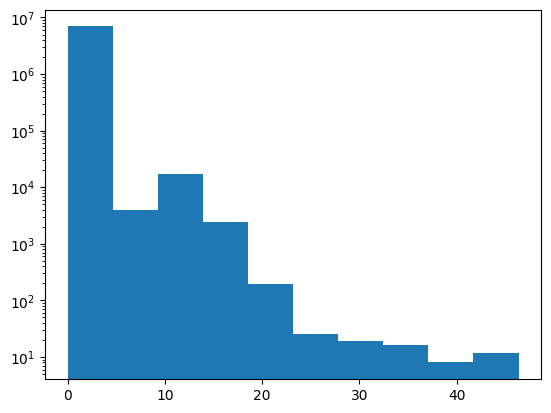

In [23]:
plt.hist(adata.obsp["distances"].A.flatten())
plt.yscale("log")

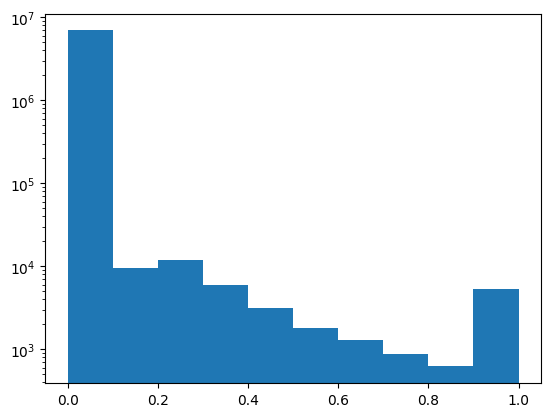

In [24]:
plt.hist(adata.obsp["connectivities"].A.flatten())
plt.yscale("log")

In [25]:
np.sum(adata.obsp["rerun_distances"].A > 0, axis=1)

KeyError: 'rerun_distances'

In [ ]:
np.sum(adata.obsp["connectivities"].A > 0, axis=0)

In [ ]:
adata.obsp["neighbors"] = adata.obsp["distances"] > 0

In [ ]:
example_cell_neighbors

In [ ]:
example_cell_id = 0
example_cell_neighbors = adata.obsp["neighbors"][example_cell_id, :].A.flatten()

In [ ]:
adata[example_cell_id, :].obs

In [ ]:
adata[example_cell_neighbors, :].obs

In [ ]:
plt.figure(figsize=(5, 5))

# t-SNE
tsne0 = adata.obsm["X_tsne"][:, 0]
tsne1 = adata.obsm["X_tsne"][:, 1]
plt.scatter(
    x=tsne0,
    y=tsne1,
    s=3,
    linewidth=0,
)
plt.scatter(x=tsne0[example_cell_id], y=tsne1[example_cell_id], s=50, linewidth=0, c="k", marker="s")
plt.scatter(x=tsne0[example_cell_neighbors], y=tsne1[example_cell_neighbors], s=8, linewidth=0, c="tab:red")


plt.title("t-SNE")
plt.axis("off")
plt.gca().set_aspect("equal")

In [ ]:
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(adata.obsp["distances"].A[:50, :50])
plt.subplot(1, 2, 2)
plt.imshow(adata.obsp["connectivities"].A[:50, :50])

In [ ]:
plt.hist(adata.obsp["distances"].A.flatten())
plt.yscale("log")

Text here!

![Multidimensional information for cells and genes in `obsm` and `varm`](img/obspvarp.png "Multidimensional information for cells and genes in `obsm` and `varm`")

And here!

In [ ]:
example = "more code here"

### Unstructured annotations or general metadata in `uns`

Text here!

![Multidimensional information for cells and genes in `obsm` and `varm`](img/anndata_schema_full.png "Multidimensional information for cells and genes in `obsm` and `varm`")

And here!

In [ ]:
example = "more code here"

### Subsetting `AnnData` objects

`AnnData` objects allow consistent subsetting of genes, cells or both.
There are several options to subset:
 - by name index (=`var_names` and/or `obs_names`) - in our example that would be lists of gene names `['LYZ','TUBB1','MALAT1']` or cell barcodes `[AAACATACAACCAC-1', 'AAACATTGAGCTAC-1', 'AAACATTGATCAGC-1']`
 - by numerical index - e.g. `:10` or `0:10` for the first 10 gene/cell, `5:10` for the sixth to the tenth, or `[0,2,4]` for the first, third and fifth
 - by boolean index - e.g. our flag for low-quality cells `adata.obs['is_low_quality']` or an index to all cells in the B cell cluster as in  `adata.obs['louvain']=='B cells'`
 
All of these index operations can be combined, and will automatically subset the active data in `adata.X`, all `layers`, and all annotation fields to the selected subset. For example, if we want to get the first five cells in the data for three specific genes we are interested in, `obs` and `var` will be subsetted

In [ ]:
adata_small = adata[:5, ["LYZ", "FOS", "MALAT1"]]
adata_small.shape

In [ ]:
# active data (log-normalized counts) after subsetting
adata_small.X.A

In [ ]:
# raw data layer after subsetting
adata_small.layers["raw"].A

In [ ]:
# cell annotations after subsetting
adata_small.obs

In [ ]:
# gene annotations after subsetting
adata_small.var

Lets also try some boolean indexing, where we keep the gene axis unchanged (using `:`), and keeping only the high quality cells (by inverting `adata.obs['is_low_quality']` with the "NOT" operator `~`)

In [ ]:
adata_high_quality = adata[~adata.obs["is_low_quality"], :]

In [ ]:
# obs data frame after subsettings shows that the low-quality cells are gone
adata_high_quality.obs

### Section on / link to  concat&merge tutorial?

### Section on / link to  backed-mode tutorial?

In [ ]:
# there was a section on that in the old tutorial

### Section on .copy() and views-vs-copies?

In [ ]:
# there was one in the old tutorial

### Section on read/write h5ad to disk

In [ ]:
# there was one in the old tutorial

## Exploring the `MuData` object